In [1]:
import regularized_differentiation.regularized_gradient
import regularized_differentiation.differentiation
import numpy as np
PATH = '/home/rickchartrand/tvdiff/regularized_differentiation/'  # FIXME: path to top-level repo folder

## Example of Sec. 4.1

In [2]:
inputs = np.arange(-256, 256) / 100.0
X, Y  = np.meshgrid(inputs, inputs)

#### create test function, add noise

In [3]:
f0 = np.abs(X) + np.abs(Y)
f = f0 + 0.1 * np.random.randn(512, 512)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

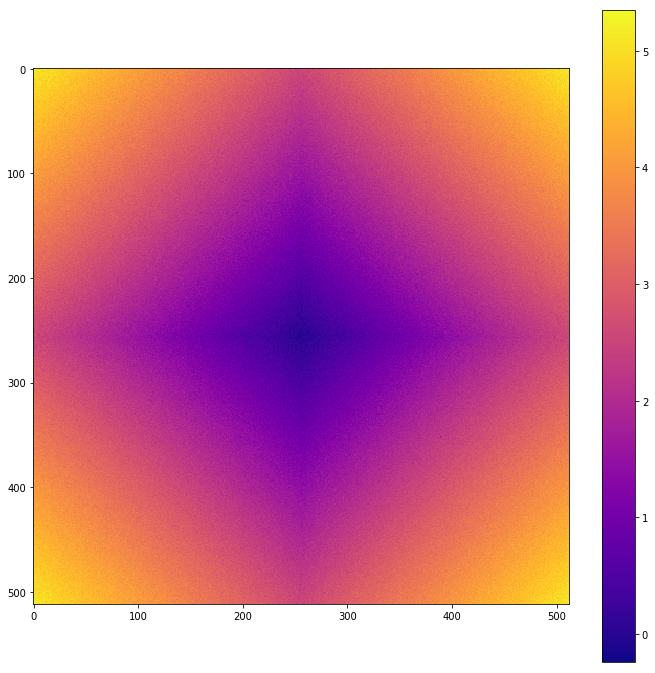

In [5]:
plt.close()
plt.figure(figsize=(12, 12))
plt.imshow(f, cmap='plasma')
plt.colorbar()

In [6]:
dx, dy = regularized_differentiation.differentiation.make_differentiation_matrices(512, 512)

In [7]:
dxf = (dx * f.ravel()).reshape(512, 512)
dyf = (dy * f.ravel()).reshape(512, 512)

#### f isn't that noisy, but naive derivative is very noisy

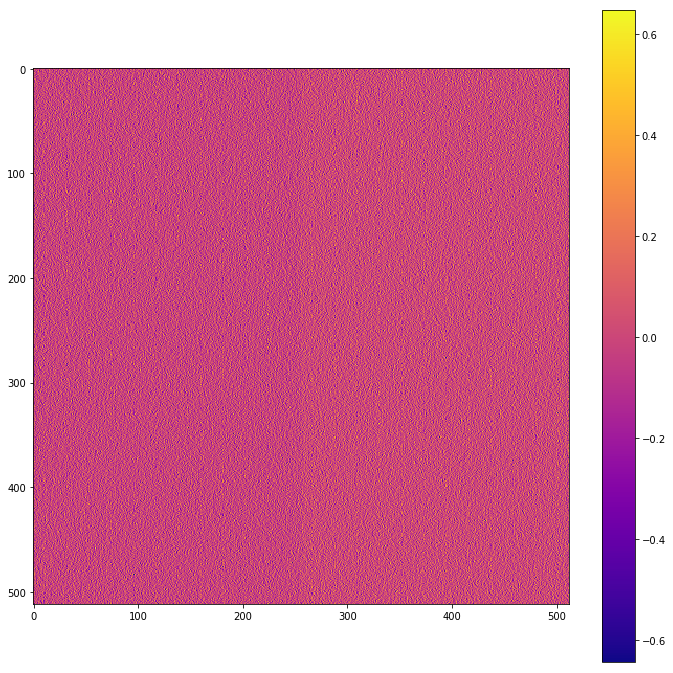

In [8]:
plt.close()
plt.figure(figsize=(12, 12))
plt.imshow(dxf, cmap='plasma')
plt.colorbar()

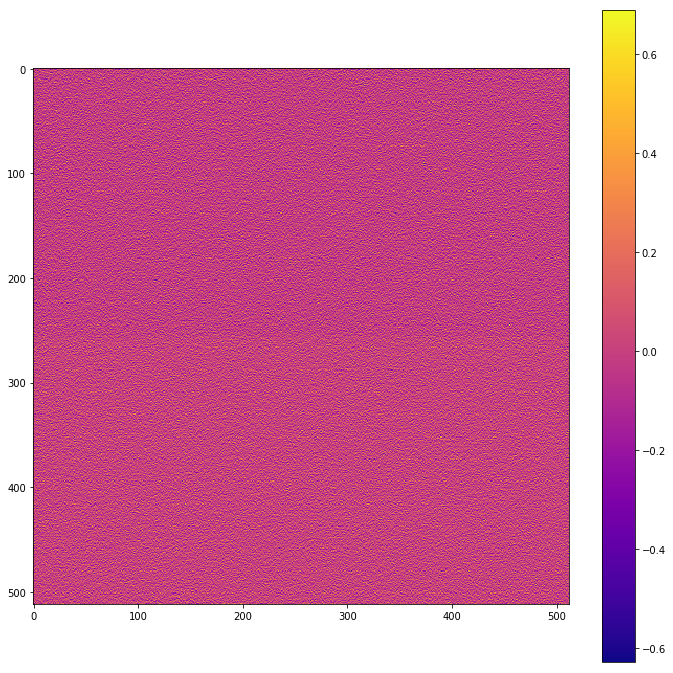

In [9]:
plt.close()
plt.figure(figsize=(12, 12))
plt.imshow(dyf, cmap='plasma')
plt.colorbar()

#### compute regularized gradient. parameters chosen to give smallest RMSE relative to f0

In [10]:
%%time
gradient = regularized_differentiation.regularized_gradient.tv_regularized_gradient(
    f, Dx=dx, Dy=dy, tuning_parameter=0.33, splitting_parameter=1.5e-2, iterations=100, diagnostics=False)

CPU times: user 3.24 s, sys: 24 ms, total: 3.26 s
Wall time: 3.25 s


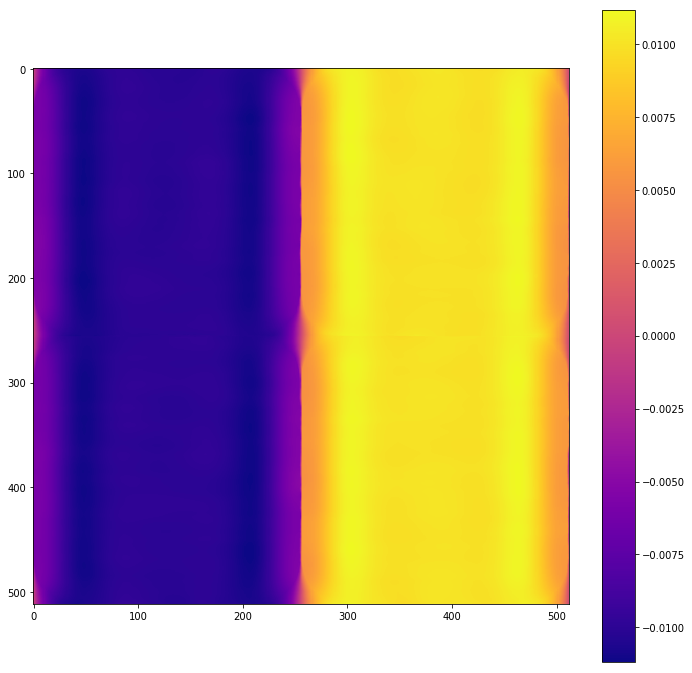

In [11]:
plt.close()
plt.figure(figsize=(12, 12))
plt.imshow(gradient[0], cmap='plasma')
plt.colorbar()

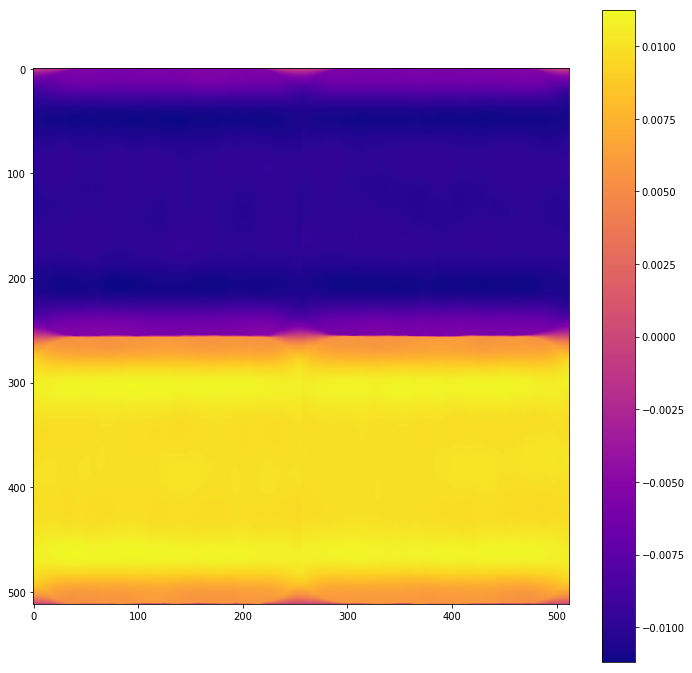

In [12]:
plt.close()
plt.figure(figsize=(12, 12))
plt.imshow(gradient[1], cmap='plasma')
plt.colorbar()

## Example of Sec. 4.2

#### Sentinel-1A image of Vietnam, VV polarization. Taking the log makes the noise _approximately_ additive, white Gaussian.

In [13]:
import skimage.io
I = np.log(skimage.io.imread(PATH + 'examples/Vietnam_S1A_VV.png').astype(np.float64))
print(I.shape)

(3072, 3072)


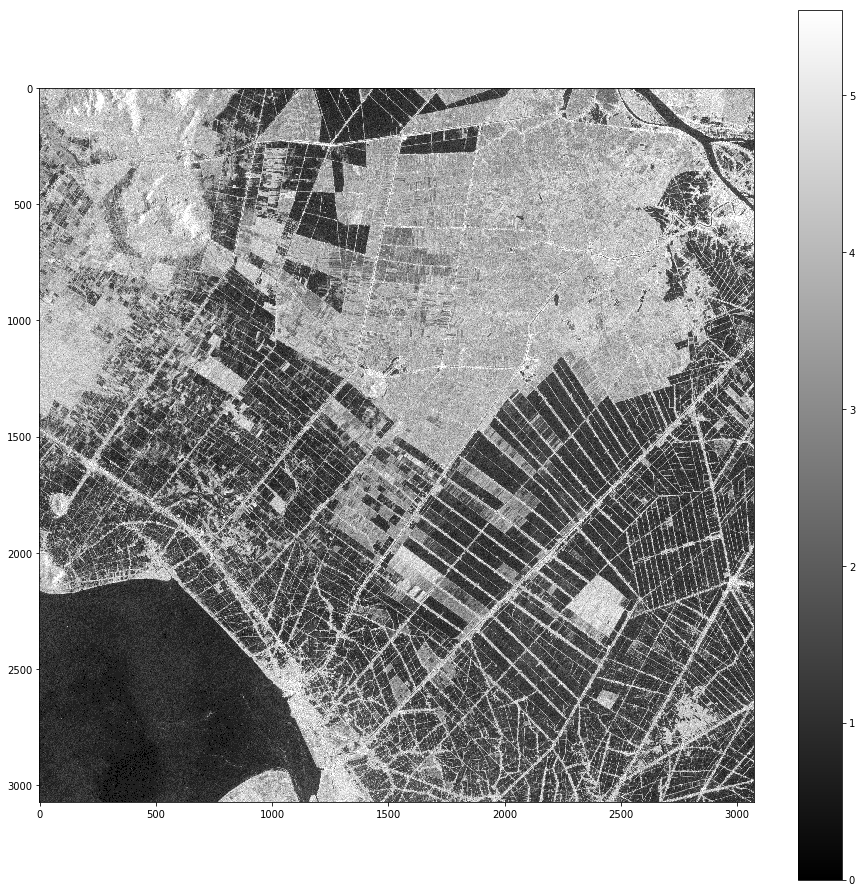

In [14]:
plt.close()
plt.figure(figsize=(16, 16))
plt.imshow(I, cmap='gray')
plt.colorbar()

In [15]:
Dx, Dy = regularized_differentiation.differentiation.make_differentiation_matrices(3072, 3072)

In [16]:
DxI = (Dx * I.ravel()).reshape(3072, 3072)
DyI = (Dy * I.ravel()).reshape(3072, 3072)
DI = np.sqrt(DxI ** 2 + DyI ** 2)

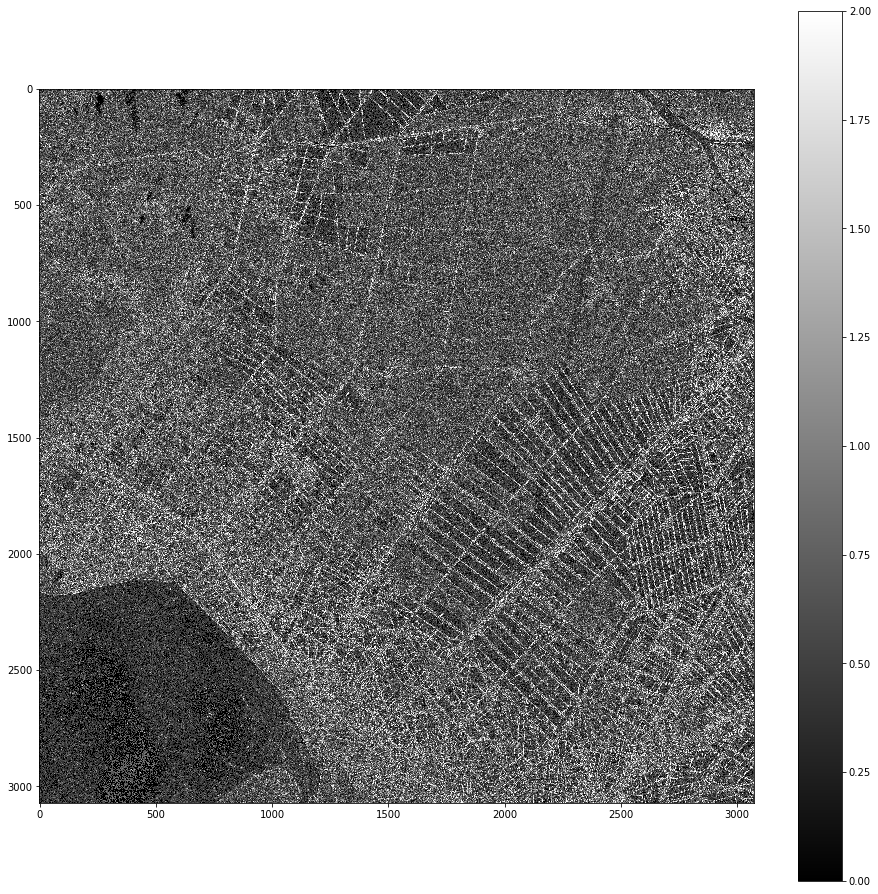

In [17]:
plt.close()
plt.figure(figsize=(16, 16))
plt.imshow(DI, cmap='gray', vmax=2)
plt.colorbar()

In [18]:
naive_theta = np.zeros((3072, 3072))
mask = (np.abs(DxI) > 1e-6) * (DI > 1e0)
naive_theta[mask] = np.arctan(DyI[mask] / DxI[mask])

#### Computing gradient angles from naive gradient doesn't give a useful result.

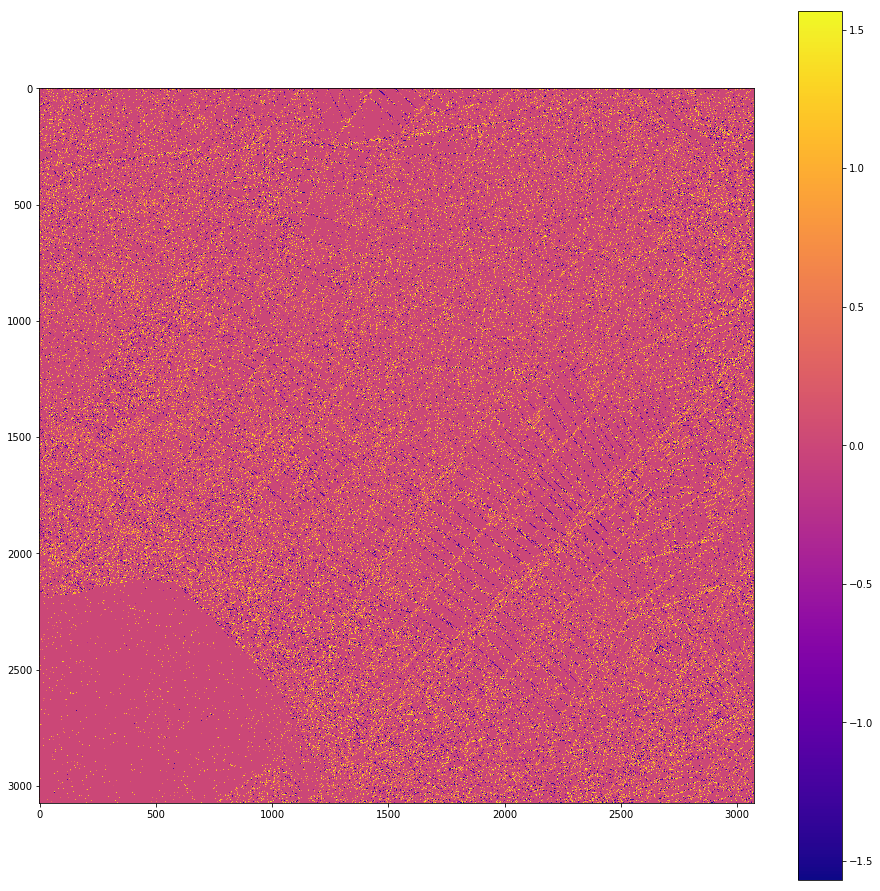

In [19]:
plt.close()
plt.figure(figsize=(16, 16))
plt.imshow(naive_theta, cmap='plasma')
plt.colorbar()

In [20]:
%%time
grad_I = regularized_differentiation.regularized_gradient.tv_regularized_gradient(
    I, Dx=Dx, Dy=Dy, tuning_parameter=1, splitting_parameter=1, iterations=10, diagnostics=True)

iteration =  0, objective = 4.373e+05, constraint = 1.676e+02
iteration =  1, objective = 2.222e+05, constraint = 8.584e+01
iteration =  2, objective = 1.626e+05, constraint = 6.393e+01
iteration =  3, objective = 1.352e+05, constraint = 5.353e+01
iteration =  4, objective = 1.188e+05, constraint = 4.722e+01
iteration =  5, objective = 1.076e+05, constraint = 4.282e+01
iteration =  6, objective = 9.914e+04, constraint = 3.951e+01
iteration =  7, objective = 9.250e+04, constraint = 3.688e+01
iteration =  8, objective = 8.707e+04, constraint = 3.472e+01
iteration =  9, objective = 8.253e+04, constraint = 3.289e+01
CPU times: user 18.3 s, sys: 5.71 s, total: 24 s
Wall time: 23.9 s


In [21]:
DrI = np.sqrt(np.sum(grad_I ** 2, axis=0))
reg_theta = np.zeros((3072, 3072))
reg_mask = (np.abs(grad_I[0]) > 1e-6) * (DrI > 2e-1)
reg_theta[reg_mask] = np.arctan(grad_I[1][reg_mask] / grad_I[0][reg_mask])

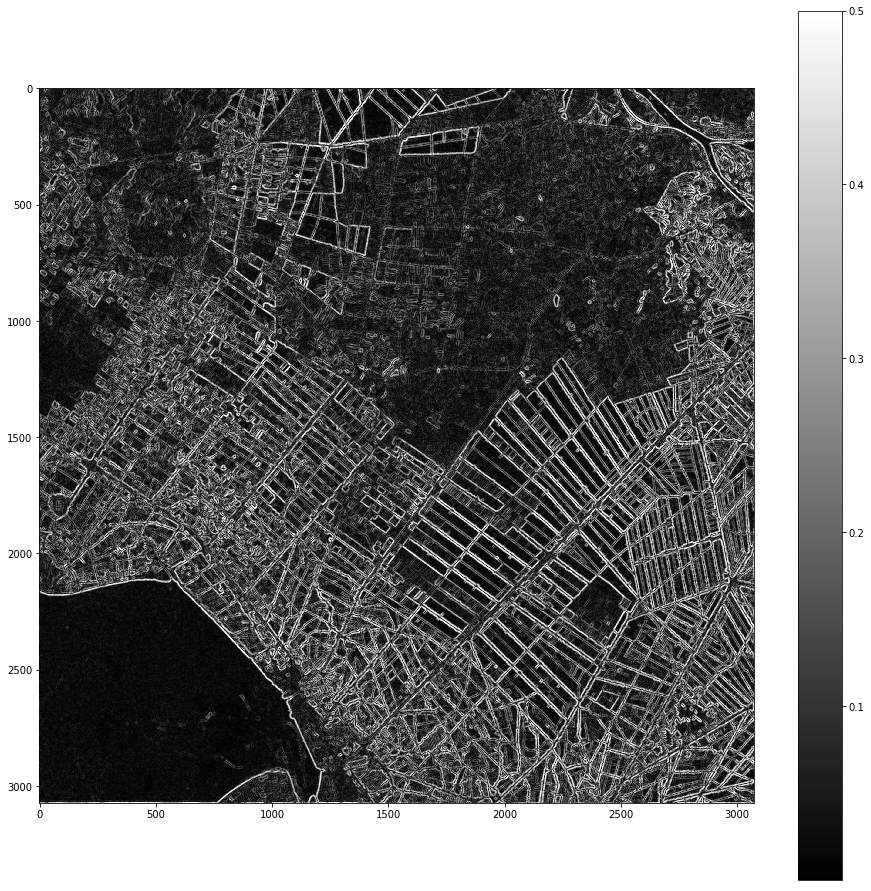

In [22]:
plt.close()
plt.figure(figsize=(16, 16))
plt.imshow(DrI, cmap='gray', vmax=0.5)
plt.colorbar()

#### Computing gradient angles from the regularized gradient gives a much cleaner result.

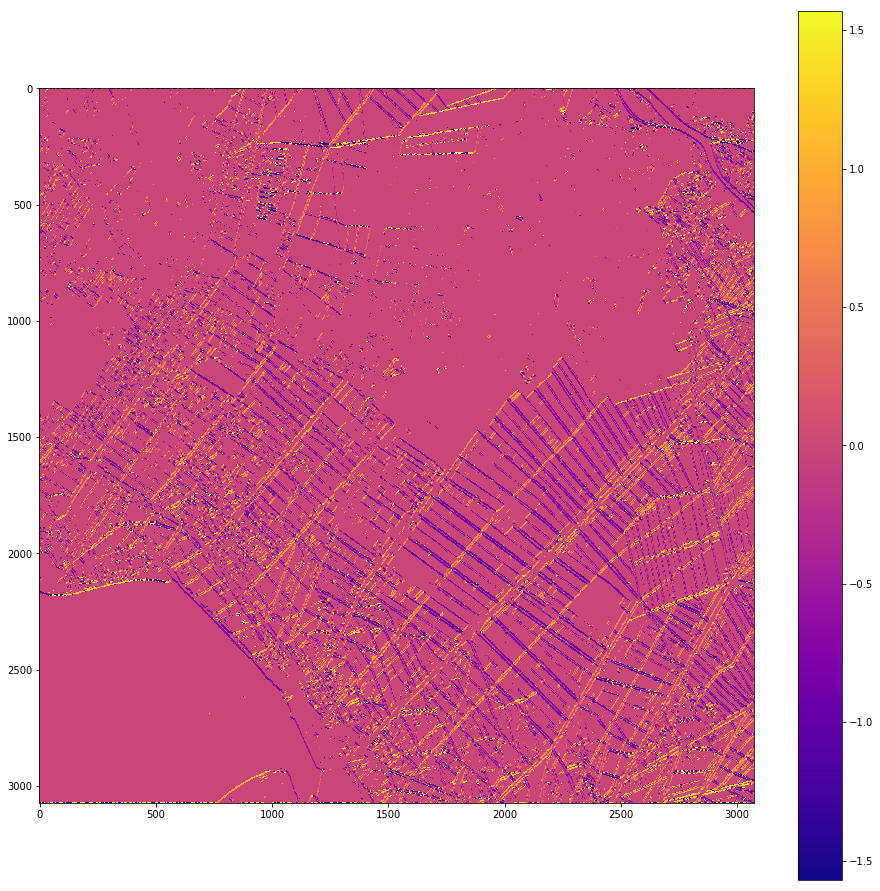

In [23]:
plt.close()
plt.figure(figsize=(16, 16))
plt.imshow(reg_theta, cmap='plasma')
plt.colorbar()